In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import timedelta
from numpy import mean
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from keras.layers import LSTM
from keras.layers import Dense

In [2]:
import seaborn as sns

In [3]:
df = pd.read_csv('municipality_bus_utilization.csv', sep = ',')

In [4]:
df

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113


In [5]:
df['timestamp']=pd.to_datetime(df['timestamp'])
df.index=df['timestamp']

In [28]:
#information about start and end times of bus services, number of bus services for each municipality

print('start times of bus service for municipalities ',df.groupby('municipality_id').timestamp.min())
print('\nend times of bus services for municipalities ',df.groupby('municipality_id').timestamp.max())
print('\nnumber of total bus services for each municipality',df.groupby('municipality_id').timestamp.count())
print('\nNumber of daily bus services for municipalities ',df.groupby(['municipality_id', pd.Grouper(freq='d')]).timestamp.count())
print('\n',np.unique(df.groupby(['municipality_id', pd.Grouper(freq='d')]).timestamp.count()))

start times of bus service for municipalities  municipality_id
0   2017-06-04 07:59:42
1   2017-06-04 07:59:42
2   2017-06-04 07:59:42
3   2017-06-04 07:59:42
4   2017-06-04 07:59:42
5   2017-06-04 07:59:42
6   2017-06-04 07:59:42
7   2017-06-04 07:59:42
8   2017-06-04 07:59:42
9   2017-06-04 07:59:42
Name: timestamp, dtype: datetime64[ns]

end times of bus services for municipalities  municipality_id
0   2017-08-19 16:30:35
1   2017-08-19 16:30:35
2   2017-08-19 16:30:35
3   2017-08-19 16:30:35
4   2017-08-19 16:30:35
5   2017-08-19 16:30:35
6   2017-08-19 16:30:35
7   2017-08-19 16:30:35
8   2017-08-19 16:30:35
9   2017-08-19 16:30:35
Name: timestamp, dtype: datetime64[ns]

number of total bus services for each municipality municipality_id
0    1307
1    1307
2    1307
3    1307
4    1307
5    1307
6    1307
7    1307
8    1307
9    1307
Name: timestamp, dtype: int64

Number of daily bus services for municipalities  municipality_id  timestamp 
0                2017-06-04    18
      

In [7]:
#resample each day according to an hour 
df2=df.groupby(['municipality_id', pd.Grouper(freq='d')]).resample('h', convention='end').max()

In [8]:
df2

timestamp  \
municipality_id timestamp  timestamp                                 
0               2017-06-04 2017-06-04 07:00:00 2017-06-04 07:59:42   
                           2017-06-04 08:00:00 2017-06-04 08:59:42   
                           2017-06-04 09:00:00 2017-06-04 09:59:48   
                           2017-06-04 10:00:00 2017-06-04 10:59:48   
                           2017-06-04 11:00:00 2017-06-04 11:59:44   
...                                                            ...   
9               2017-08-19 2017-08-19 12:00:00 2017-08-19 12:30:32   
                           2017-08-19 13:00:00 2017-08-19 13:30:35   
                           2017-08-19 14:00:00 2017-08-19 14:30:33   
                           2017-08-19 15:00:00 2017-08-19 15:29:33   
                           2017-08-19 16:00:00 2017-08-19 16:30:35   

                                                municipality_id  usage  \
municipality_id timestamp  timestamp                                     
0               2017-06-04 2017-06-04 07:00:00                0    204   
                           2017-06-04 08:00:00                0    332   
                           2017-06-04 09:00:00                0    485   
                           2017-06-04 10:00:00                0    583   
                           2017-06-04 11:00:00                0    614   
...                                                         ...    ...   
9               2017-08-19 2017-08-19 12:00:00                9    849   
                           2017-08-19 13:00:00                9    941   
                           2017-08-19 14:00:00                9    983   
                           2017-08-19 15:00:00                9    976   
                           2017-08-19 16:00:00                9    879   

                                                total_capacity  
municipality_id timestamp  timestamp                            
0               2017-06-04 2017-06-04 07:00:00            2813  
                           2017-06-04 08:00:00            2813  
                           2017-06-04 09:00:00            2813  
                           2017-06-04 10:00:00            2813  
                           2017-06-04 11:00:00            2813  
...                                                        ...  
9               2017-08-19 2017-08-19 12:00:00            1332  
                           2017-08-19 13:00:00            1332  
                           2017-08-19 14:00:00            1332  
                           2017-08-19 15:00:00            1332  
                           2017-08-19 16:00:00            1332  

[6740 rows x 4 columns]

In [9]:
df2=df2.droplevel([0,1]) 

In [10]:
df2.rename(columns={"timestamp": "old_ts"},inplace=True)

In [11]:
df2

,old_ts,municipality_id,usage,total_capacity
timestamp,,,,
2017-06-04 07:00:00,2017-06-04 07:59:42,0,204,2813
2017-06-04 08:00:00,2017-06-04 08:59:42,0,332,2813
2017-06-04 09:00:00,2017-06-04 09:59:48,0,485,2813
2017-06-04 10:00:00,2017-06-04 10:59:48,0,583,2813
2017-06-04 11:00:00,2017-06-04 11:59:44,0,614,2813
...,...,...,...,...
2017-08-19 12:00:00,2017-08-19 12:30:32,9,849,1332
2017-08-19 13:00:00,2017-08-19 13:30:35,9,941,1332
2017-08-19 14:00:00,2017-08-19 14:30:33,9,983,1332


In [12]:
df2[df2.isnull().any(axis=1)]

,old_ts,municipality_id,usage,total_capacity
timestamp,,,,


In [13]:
grouped = df2.groupby('municipality_id')

In [14]:
#With a quick stationarity test Augmented Dickey-Fuller, usage of municipality 0 seems like as non-stationary
from statsmodels.tsa.stattools import adfuller
for g in grouped.groups:
  group = grouped.get_group(g)
  result = adfuller(group.usage.values)
  print('for muni'+str(g)+' ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

for muni0 ADF Statistic: -1.857021
p-value: 0.352542
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
for muni1 ADF Statistic: -3.158221
p-value: 0.022534
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
for muni2 ADF Statistic: -5.751547
p-value: 0.000001
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
for muni3 ADF Statistic: -7.228833
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
for muni4 ADF Statistic: -6.472059
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
for muni5 ADF Statistic: -6.404415
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
for muni6 ADF Statistic: -3.768107
p-value: 0.003251
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
for muni7 ADF Statistic: -4.993825
p-value: 0.000023
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
for muni8 ADF Statistic: -8.005984
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
for muni9 ADF Statistic: -5.063090
p-

In [15]:
def moving_average_forecast(series, window_size):
    forecast = []
    
    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())
    
    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

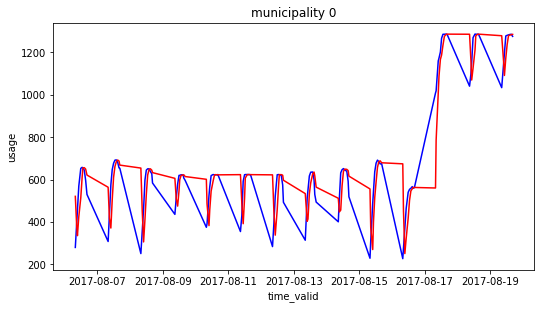

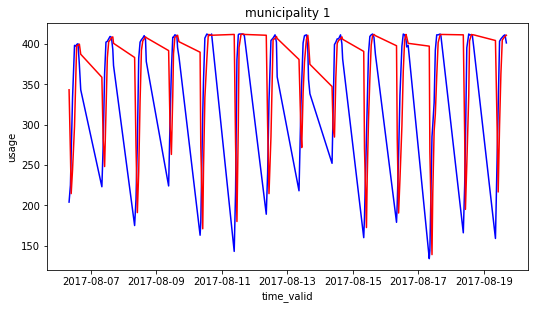

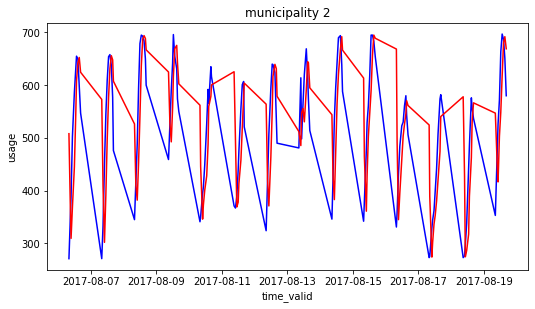

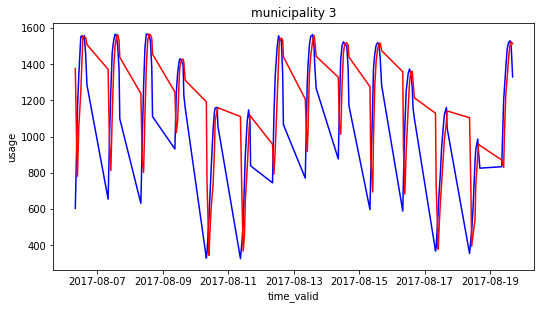

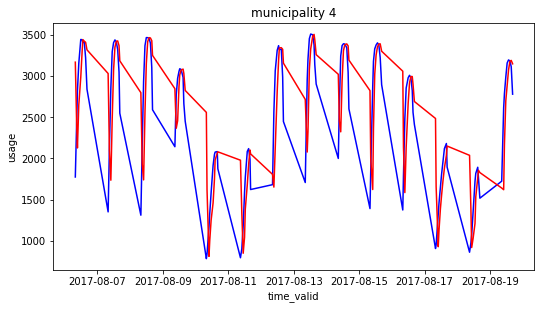

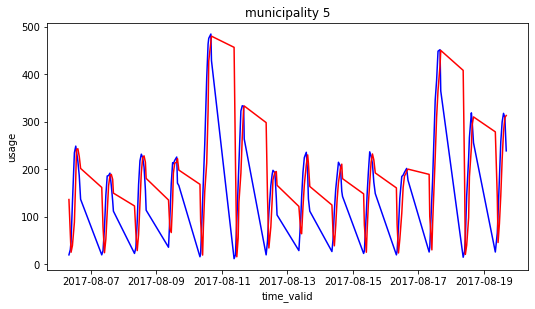

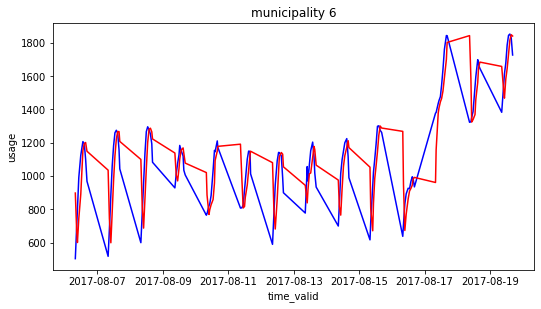

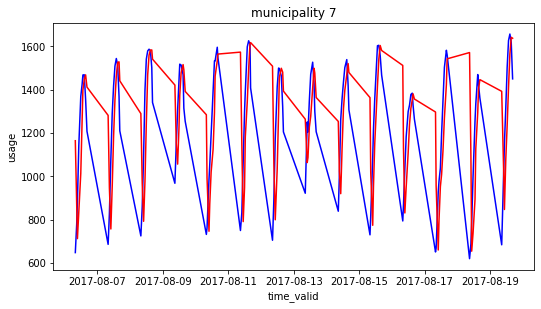

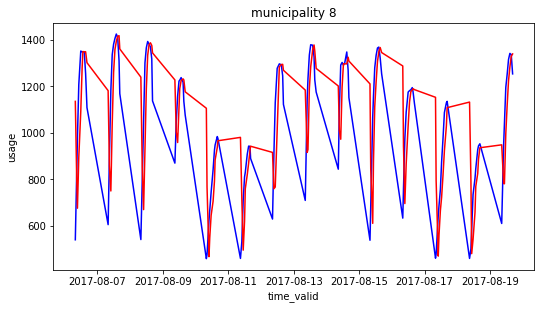

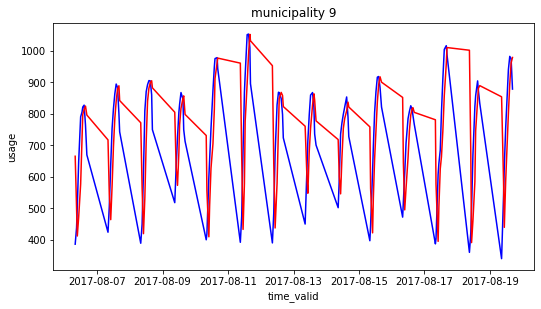

In [16]:
moving_avg_mse = []
moving_avg_mae = []
for g in grouped.groups:
  group = grouped.get_group(g)
  split_time = group.old_ts[-1:]-timedelta(weeks = 2)
    
  X = group.usage.values
  x_train = group.loc[(group.old_ts < split_time[0])].usage.values
  time_train = group.loc[(group.old_ts < split_time[0])].old_ts.values

  x_valid = group.loc[(group.old_ts > split_time[0])].usage.values
  time_valid = group.loc[(group.old_ts > split_time[0])].old_ts.values
    
  # Generate the moving average forecast
  moving_avg = moving_average_forecast(X, 2)[len(x_train) - 2:]

  # Plot the results
  if g>4:
    i=1
    j=g-5
  else:
    i=0
    j=g
  plt.figure(figsize=(50,10))
  ax = plt.subplot2grid((2,5), (i,j))
  ax.set_xlabel('time_valid')
  ax.set_ylabel('usage')
  ax.title.set_text('municipality '+str(g))
  ax.plot(time_valid ,x_valid, 'b-', time_valid, moving_avg, 'r-')

  moving_avg_mse.append(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
  moving_avg_mae.append(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

plt.show()

In [17]:
#prepare features and labels for LSTM model

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [19]:
# Build the model
def create_model(window_size):
  tf.keras.backend.clear_session()
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
  ])
  return model

In [20]:
#With LearningRateScheduler, learning rate which gives to minimum loss can be found each municipality
def find_lr(model_tune, data):
  #Tune the Learning Rate
  # Set the learning rate scheduler
  lr_schedule = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-8 * 10**(epoch / 20))

  # Initialize the optimizer
  optimizer = tf.keras.optimizers.SGD(momentum=0.9)

  # Set the training parameters
  model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

  # Train the model
  history = model_tune.fit(data, epochs=100, callbacks=[lr_schedule], verbose = 0)
  min_loss = history.history['loss']
  idx = pd.Series(min_loss).idxmin()
  lr = history.history['lr'][idx]
  return(lr)

In [21]:
#parameters
window_size = 10
batch_size = 16
shuffle_buffer_size = len(x_train)

Epoch 1/150
34/34 [==============================] - 5s 15ms/step - loss: 246.4024 - mae: 246.9012
Epoch 2/150
34/34 [==============================] - 1s 14ms/step - loss: 167.6851 - mae: 168.1846
Epoch 3/150
34/34 [==============================] - 1s 15ms/step - loss: 148.3834 - mae: 148.8829
Epoch 4/150
34/34 [==============================] - 1s 15ms/step - loss: 142.9053 - mae: 143.4036
Epoch 5/150
34/34 [==============================] - 1s 14ms/step - loss: 139.9590 - mae: 140.4572
Epoch 6/150
34/34 [==============================] - 1s 14ms/step - loss: 137.6969 - mae: 138.1960
Epoch 7/150
34/34 [==============================] - 1s 14ms/step - loss: 135.6073 - mae: 136.1065
Epoch 8/150
34/34 [==============================] - 1s 14ms/step - loss: 135.0286 - mae: 135.5268
Epoch 9/150
34/34 [==============================] - 1s 15ms/step - loss: 132.7437 - mae: 133.2427
Epoch 10/150
34/34 [==============================] - 1s 14ms/step - loss: 130.7923 - mae: 131.2910
Epoch 11/

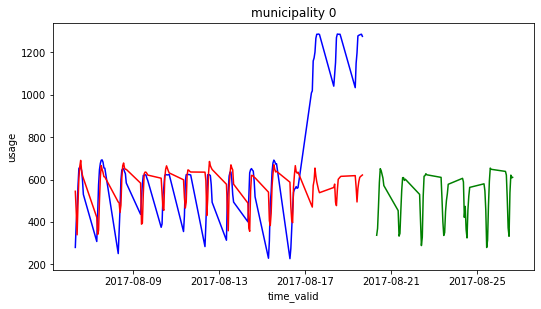

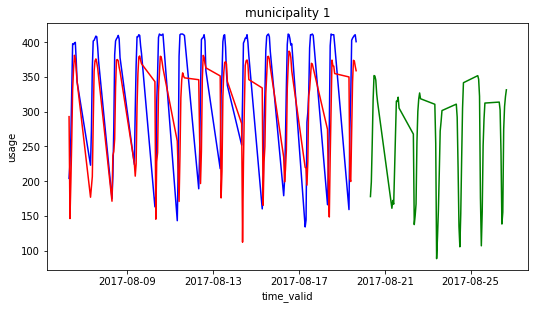

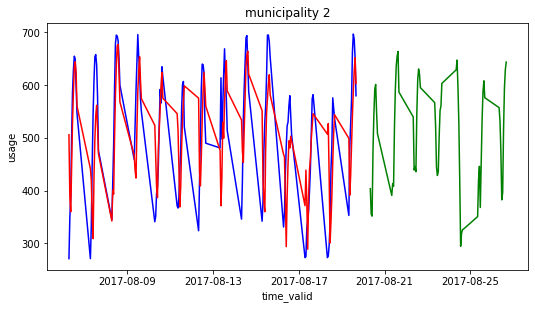

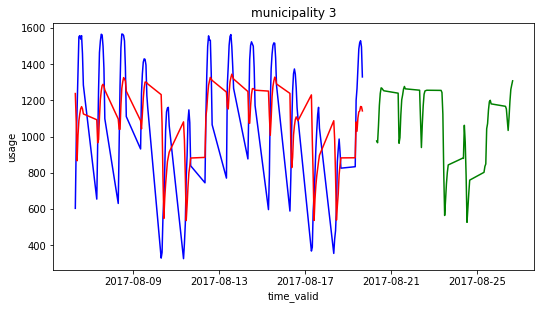

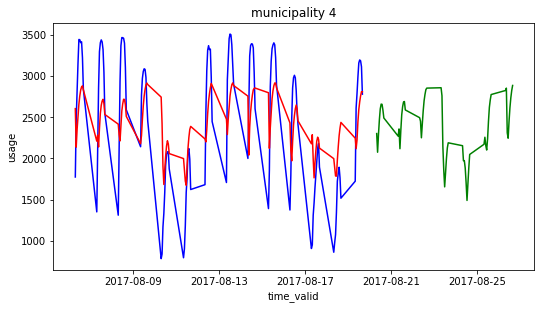

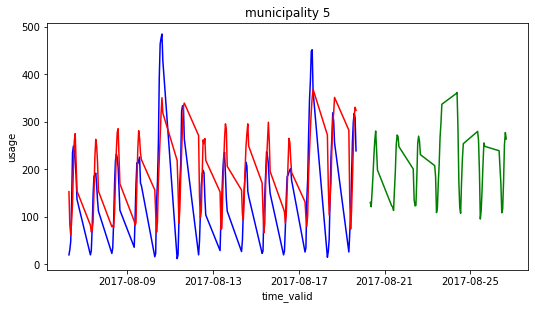

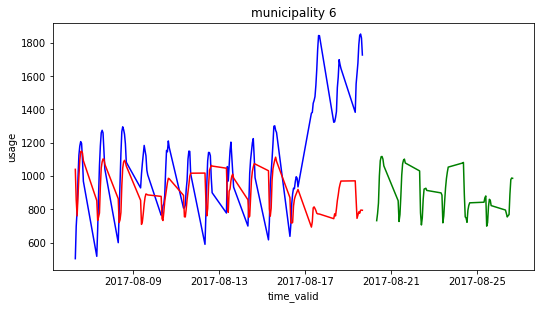

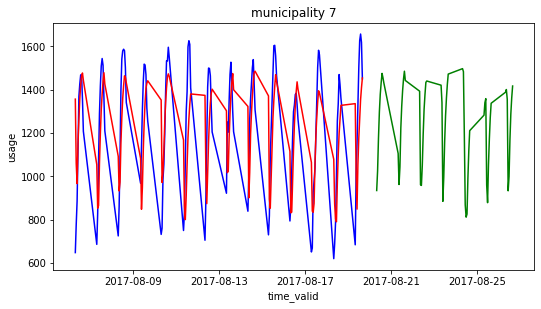

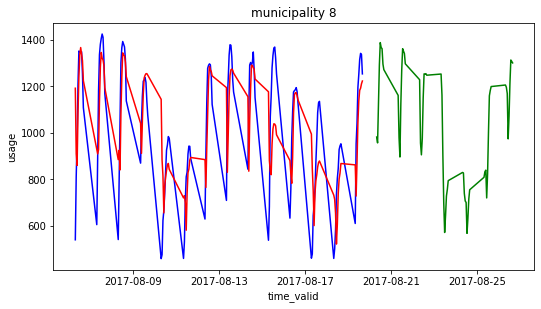

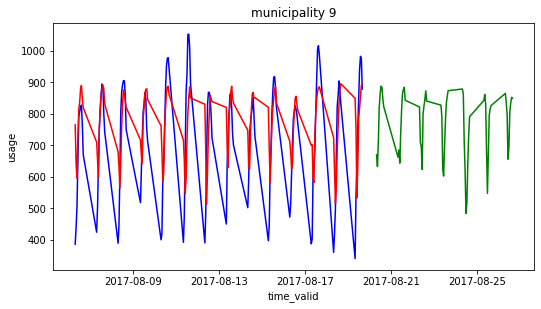

In [45]:
lstm_mse = []
lstm_mae = []
next_week = []
for g in grouped.groups:
  group = grouped.get_group(g)
  split_time = group.index[-1:]-timedelta(weeks = 2)
  
  X = group.usage.values
  x_train = group.loc[(group.index < split_time[0])].usage.values
  time_train = group.loc[(group.index < split_time[0])].index.values

  x_valid = group.loc[(group.index > split_time[0])].usage.values
  time_valid = group.loc[(group.index > split_time[0])].index.values
  
  # Generate windowed dataset
  dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
  
  model_tune = create_model(window_size)
  lr = find_lr(model_tune, dataset)
  
  model = create_model(window_size)

  optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

  # Set the training parameters
  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
  
  model.fit(dataset,epochs=150)

  forecast_valid = []

  # Reduce the original series
  forecast_series = X[len(x_train) - window_size:]

  # Use the model to predict data points per window size
  for time in range(len(forecast_series) -1-window_size):
    forecast_valid.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

  # Convert to a numpy array and drop single dimensional axes
  results_valid = np.array(forecast_valid).squeeze()

  forecast_next = []

  # Reduce the original series for next week
  forecast_series_n = X[:63+window_size] #values for the prediction of the last week of test data

  # Use the model to predict data points per window size
  for time in range(len(forecast_series_n) - window_size):
    forecast_next.append(model.predict(forecast_series_n[time:time + window_size][np.newaxis]))

  results_next = np.array(forecast_next).squeeze()
  results_next = np.reshape(results_next,(63,1))
  next_week.append([results_next])
  
  next_week_time = [group[(group.index>='2017-08-19')].index+pd.Timedelta(days=i) for i in range(1,8)]
  next_week_time = np.reshape(next_week_time,(63,1))

  # Plot the valid, predicted valid and predicted next week values
  if g>4:
    i=1
    j=g-5
  else:
    i=0
    j=g
  plt.figure(figsize=(50,10))
  ax = plt.subplot2grid((2,5), (i,j))
  ax.set_xlabel('time_valid')
  ax.set_ylabel('usage')
  ax.title.set_text('municipality '+str(g))
  ax.plot(time_valid ,x_valid, 'b-', time_valid, results_valid, 'r-',next_week_time, results_next, 'g-')

  lstm_mse.append(tf.keras.metrics.mean_squared_error(x_valid, results_valid).numpy())
  lstm_mae.append(tf.keras.metrics.mean_absolute_error(x_valid, results_valid).numpy())

plt.show()

In [77]:
print('mean absolute error of moving average model for municipalities respectively\n',moving_avg_mae)

mean absolute error of moving average model for municipalities respectively
 [83.92105263157895, 60.27067669172932, 85.34210526315789, 216.86466165413535, 430.0338345864662, 74.31203007518798, 137.0639097744361, 217.75187969924812, 169.30075187969925, 136.07894736842104]


In [76]:
print('mean absolute error of moving average model for municipalities respectively\n',lstm_mae)

mean absolute error of moving average model for municipalities respectively
 [202.30077, 63.32668, 78.02375, 259.9569, 521.507, 68.28094, 290.55225, 194.86336, 151.38535, 108.754295]


In [56]:
next_week = np.reshape(next_week,(1,630))
tt=[next_week_time.reshape(1,63)]*10
flat_time = [t for sublist in tt for t in sublist]
flat_time = np.reshape(flat_time, (1,630))
muni =[np.full(63, j) for j in range(10)]
municipality = [y for ys in muni for y in ys]

In [65]:
#Dataframe which includes next week values
next_week_df = pd.DataFrame(data = next_week[0], columns = ['usage'], index = flat_time[0])

In [66]:
next_week_df['municipality'] = municipality

In [67]:
next_week_df

,usage,municipality
2017-08-20 08:00:00,337.442902,0
2017-08-20 09:00:00,370.056213,0
2017-08-20 10:00:00,472.717010,0
2017-08-20 11:00:00,586.531860,0
2017-08-20 12:00:00,651.696533,0
...,...,...
2017-08-26 12:00:00,694.924438,9
2017-08-26 13:00:00,805.837830,9
2017-08-26 14:00:00,834.709656,9
2017-08-26 15:00:00,852.632996,9
